In [46]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import import_ipynb
from preprocessing import params

In [47]:
News = pd.read_csv('News_proper', index_col = 0)

In [48]:
News = News.drop('Words', axis=1)

In [49]:
News.head()

,Article,ticker,time_tz,valid,start,end,CAR,hour,class,Negative,Neutral,Positive,Sentiment,Score
0,LOS ANGELES (Reuters) - Amazon.com Inc AMZN.O ...,AMZN,2019-11-06 11:43:00-05:00,True,2019-11-06 10:43:00-05:00,2019-11-06 12:43:00-05:00,-0.001852,10,NaN,0.010688,0.807917,0.077167,Neutral,0
1,NEW DELHI (Reuters) - India's antitrust body h...,AMZN,2019-11-01 10:03:00-04:00,True,2019-11-01 09:03:00-04:00,2019-11-01 11:03:00-04:00,-0.001099,9,NaN,0.020621,0.763345,0.078103,Neutral,0
2,WASHINGTON (Reuters) - If Amazon.com decides t...,AMZN,2019-10-28 15:34:00-04:00,True,2019-10-28 14:34:00-04:00,2019-10-28 16:34:00-04:00,0.000605,14,NaN,0.033970,0.769364,0.105727,Positive,1
3,(Reuters) - Amazon.com Inc's AMZN.O firm grip ...,AMZN,2019-10-28 12:31:00-04:00,True,2019-10-28 11:31:00-04:00,2019-10-28 13:31:00-04:00,0.001594,11,NaN,0.014182,0.798227,0.096682,Neutral,0
4,WASHINGTON (Reuters) - Microsoft Corp MSFT.O h...,AMZN,2019-10-27 12:02:00-04:00,True,2019-10-27 11:02:00-04:00,2019-10-27 13:02:00-04:00,0.000000,11,NaN,0.039538,0.693641,0.087333,Neutral,0


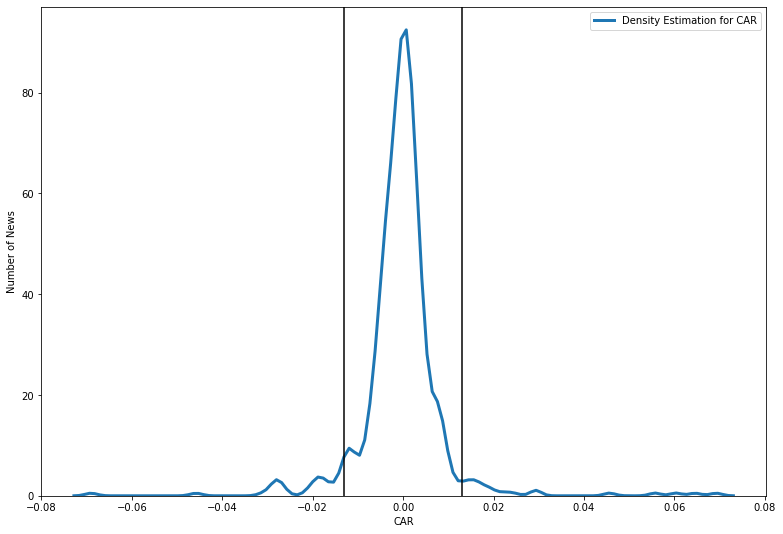

In [50]:
import seaborn as sns

fig, ax = plt.subplots(figsize= (13, 9))
sns.distplot(News['CAR'], ax=ax, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'Density Estimation for CAR')
plt.ylabel("Number of News")
plt.axvline(x=0.013, color = 'black')
plt.axvline(x=-0.013, color = 'black')

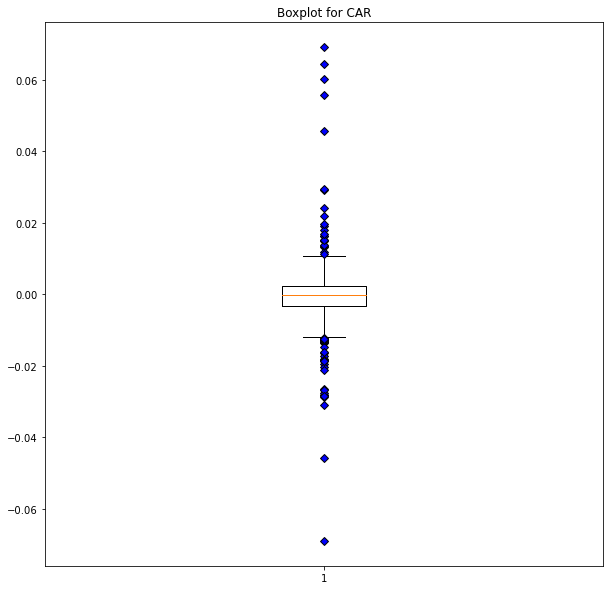

In [51]:
green_diamond = dict(markerfacecolor='b', marker='D')
fig3, ax3 = plt.subplots()
fig3.set_size_inches(10, 10)
ax3.set_title('Boxplot for CAR')
ax3.boxplot(News['CAR'], flierprops=green_diamond)
plt.show()

In [52]:
conditions = [(News['CAR'] <= -0.005), 
             (News['CAR'] > -0.005) & (News['CAR'] < 0.005),
             (News['CAR'] >= 0.005)]

values = [-1, 0, 1]

News['class'] = np.select(conditions, values)

In [53]:
News[['class', 'Score', 'Article']].groupby(['class', 'Score']).count()

Article
class Score         
-1    -1           5
       0          82
       1           8
 0    -1          14
       0         346
       1          54
 1    -1           3
       0          64
       1           6

In [54]:
News[['class', 'Score']].groupby('class').count()

,Score
class,
-1,95
0,416
1,73


In [55]:
News_BERT = pd.read_csv(r'C:\Users\kozyr\Downloads\News_BERT.csv', index_col = 0)

In [56]:
News_BERT['time_tz'] = pd.to_datetime(News_BERT['time_tz'])

In [57]:
Positive = News_BERT[News_BERT['class'] == 1]
Negative = News_BERT[News_BERT['class'] == -1]
Neutral = News_BERT[News_BERT['class'] == 0]

In [58]:
CAAR_pos = Positive['CAR'].mean()
CAAR_neg = Negative['CAR'].mean()
CAAR_neu = Neutral['CAR'].mean()
print(CAAR_pos, CAAR_neg, CAAR_neu)

prices = pd.read_csv('prices_BERT')
prices['time'] = pd.to_datetime(prices['time'])

0.013589028078919653 -0.012171595256751265 -4.829337776402026e-05


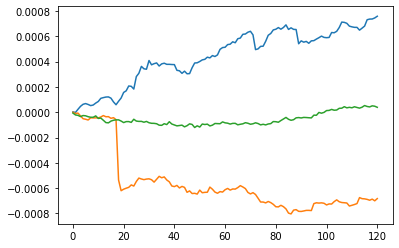

In [59]:
Positive_CAR = [0] * 1440
N = len(Positive)

for _, row in Positive[Positive['ticker'] == 'AMZN'].iterrows():
    
    beg = row['time_tz'] - pd.Timedelta("60 min")
    end = row['time_tz'] + pd.Timedelta("60 min")
    news_time = row['time_tz']
    
    for_the_news = prices[(prices['time'] >= beg) & (prices['time'] <= end)].copy()
    for_the_news['diff'] = for_the_news['time'] - news_time
    
    for_the_news['diff'] = for_the_news['diff'].apply(lambda x: x.seconds)
    for_the_news['diff'] = for_the_news['diff'].apply(lambda seconds: (seconds//60))
    
    for_the_news['AR'] = for_the_news['R_t_' + row['ticker']] - params[row['ticker']][0] - params[row['ticker']][1] * for_the_news['R_t-1_' + row['ticker']] - params[row['ticker']][2] * for_the_news['R_m']
    for_the_news['cumAR'] = for_the_news['AR'].cumsum()
    
    for a, row1 in for_the_news.iterrows():
        Positive_CAR[row1['diff']] += row1['cumAR']/N
        
P_CAR = Positive_CAR[-60:] + Positive_CAR[:61]
plt.plot(P_CAR)

Negative_CAR = [0] * 1440
N = len(Negative)

for _, row in Negative[Negative['ticker'] == 'AMZN'].iterrows():
    
    beg = row['time_tz'] - pd.Timedelta("60 min")
    end = row['time_tz'] + pd.Timedelta("60 min")
    news_time = row['time_tz']
    
    for_the_news = prices[(prices['time'] >= beg) & (prices['time'] <= end)].copy()
    for_the_news['diff'] = for_the_news['time'] - news_time
    
    for_the_news['diff'] = for_the_news['diff'].apply(lambda x: x.seconds)
    for_the_news['diff'] = for_the_news['diff'].apply(lambda seconds: (seconds//60))
    
    for_the_news['AR'] = for_the_news['R_t_' + row['ticker']] - params[row['ticker']][0] - params[row['ticker']][1] * for_the_news['R_t-1_' + row['ticker']] - params[row['ticker']][2] * for_the_news['R_m']
    for_the_news['cumAR'] = for_the_news['AR'].cumsum()
    
    for a, row1 in for_the_news.iterrows():
        Negative_CAR[row1['diff']] += row1['cumAR']/N

N_CAR = Negative_CAR[-60:] + Negative_CAR[:61]
plt.plot(N_CAR)

Neutral_CAR = [0] * 1440
N = len(Neutral)

for _, row in Neutral[Neutral['ticker'] == 'AMZN'].iterrows():
    
    beg = row['time_tz'] - pd.Timedelta("60 min")
    end = row['time_tz'] + pd.Timedelta("60 min")
    news_time = row['time_tz']
    
    for_the_news = prices[(prices['time'] >= beg) & (prices['time'] <= end)].copy()
    for_the_news['diff'] = for_the_news['time'] - news_time
    
    for_the_news['diff'] = for_the_news['diff'].apply(lambda x: x.seconds)
    for_the_news['diff'] = for_the_news['diff'].apply(lambda seconds: (seconds//60))
    
    for_the_news['AR'] = for_the_news['R_t_' + row['ticker']] - params[row['ticker']][0] - params[row['ticker']][1] * for_the_news['R_t-1_' + row['ticker']] - params[row['ticker']][2] * for_the_news['R_m']
    for_the_news['cumAR'] = for_the_news['AR'].cumsum()
    
    for a, row1 in for_the_news.iterrows():
        Neutral_CAR[row1['diff']] += row1['cumAR']/N

Ne_CAR = Neutral_CAR[-60:] + Neutral_CAR[:61]
plt.plot(Ne_CAR)

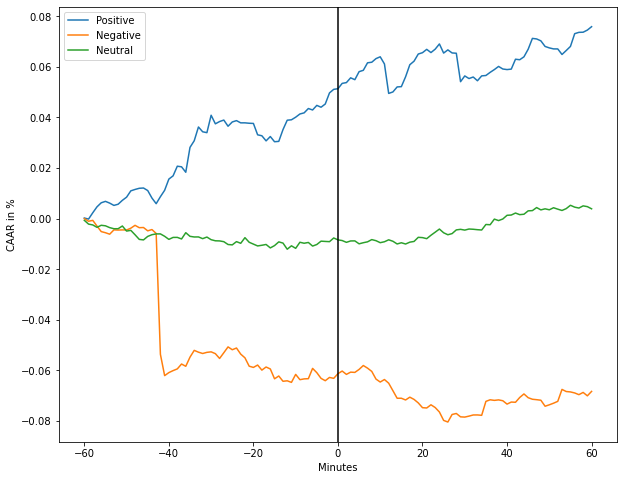

In [60]:
plt.figure(figsize=(10, 8))
plt.plot(np.linspace(-60,60,len(P_CAR)), np.array(P_CAR)*100, label = 'Positive')
plt.plot(np.linspace(-60,60,len(P_CAR)), np.array(N_CAR)*100, label = 'Negative')
plt.plot(np.linspace(-60,60,len(P_CAR)), np.array(Ne_CAR)*100, label = 'Neutral')
plt.axvline(x=0, color = 'black')
plt.legend()
plt.tick_params(left='off')
plt.xlabel("Minutes")
plt.ylabel("CAAR in %")
plt.show()

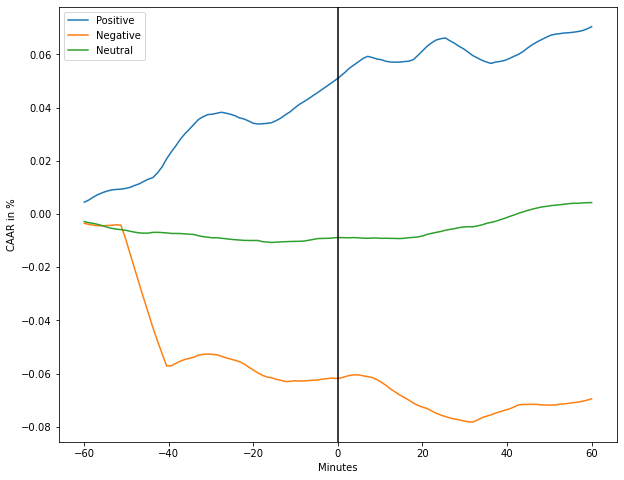

In [61]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.figure(figsize=(10, 8))
plt.plot(np.linspace(-60,60,len(running_mean(P_CAR, 10))),running_mean(np.array(P_CAR)*100, 10), label = 'Positive')
plt.plot(np.linspace(-60,60,len(running_mean(P_CAR, 10))),running_mean(np.array(N_CAR)*100, 10), label = 'Negative')
plt.plot(np.linspace(-60,60,len(running_mean(P_CAR, 10))),running_mean(np.array(Ne_CAR)*100, 10), label = 'Neutral')
plt.axvline(x=0, color = 'black')
plt.legend()
plt.tick_params(left='off')
plt.xlabel("Minutes")
plt.ylabel("CAAR in %")
plt.show()

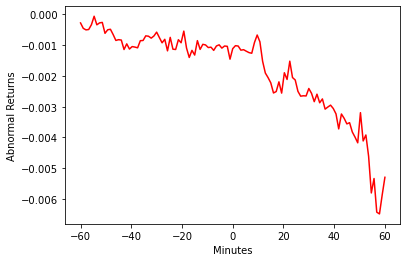

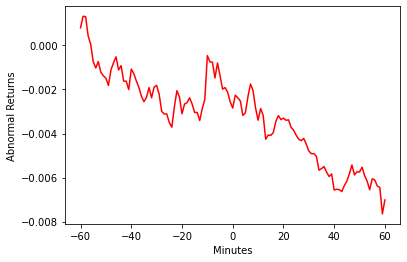

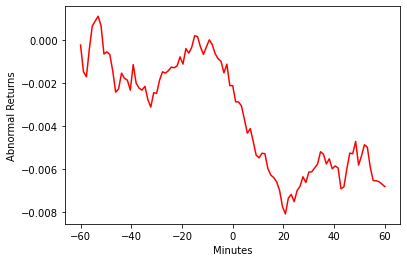

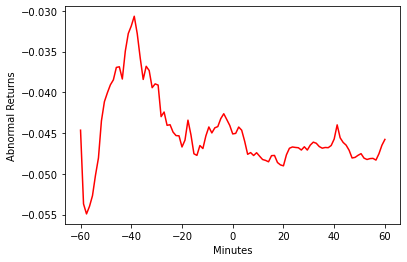

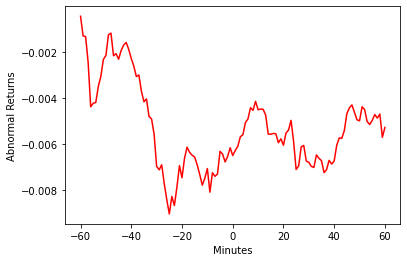

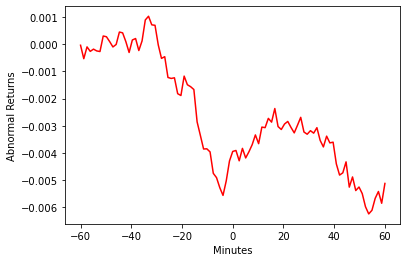

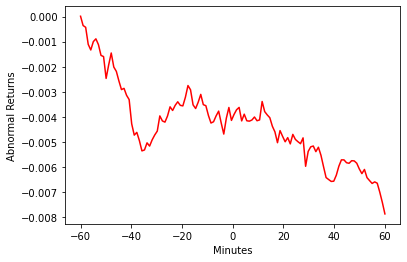

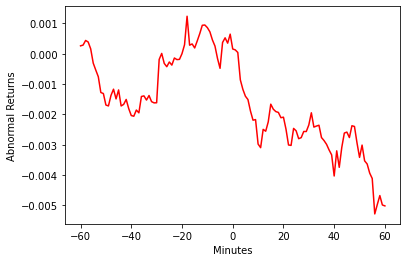

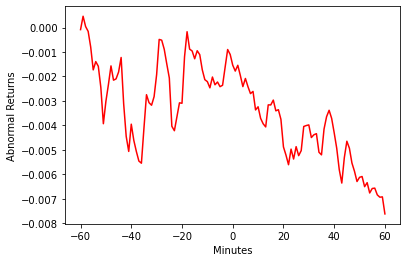

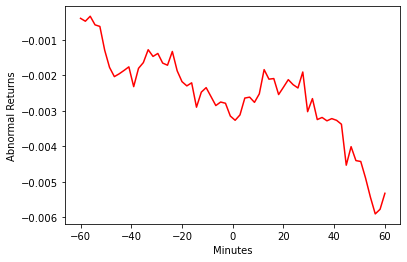

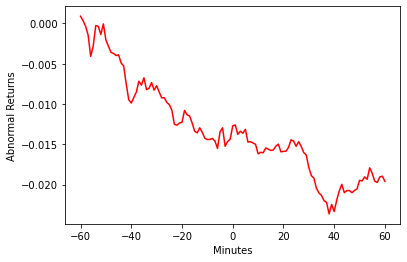

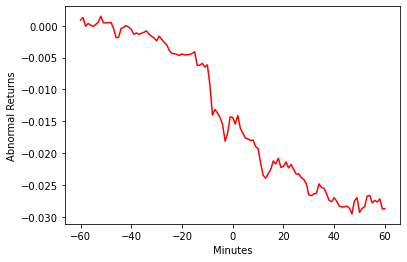

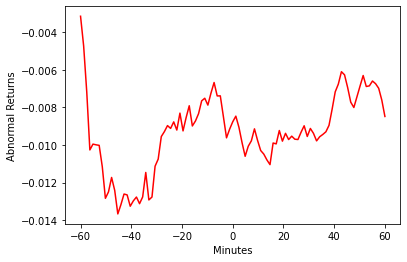

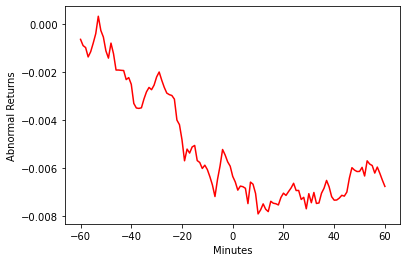

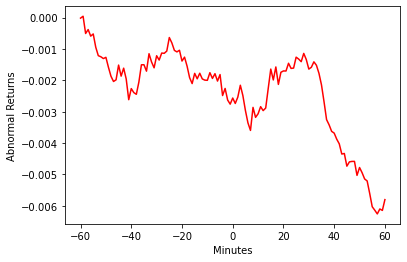

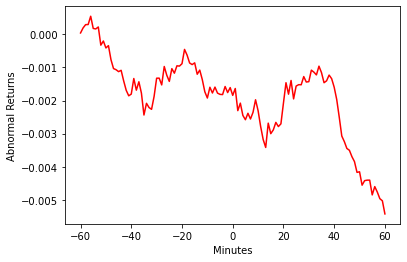

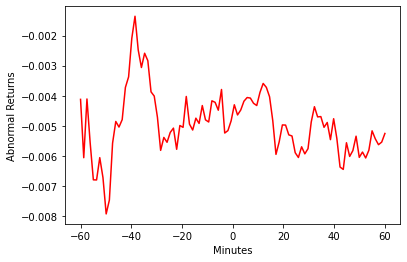

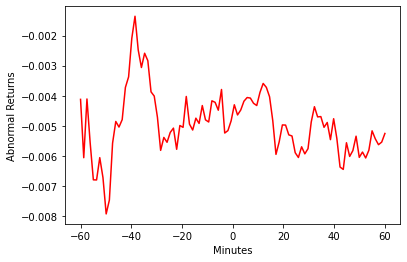

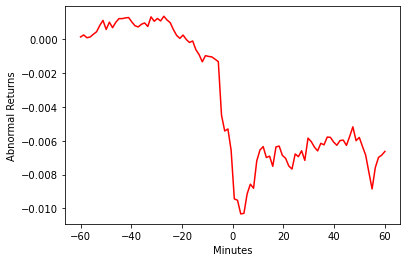

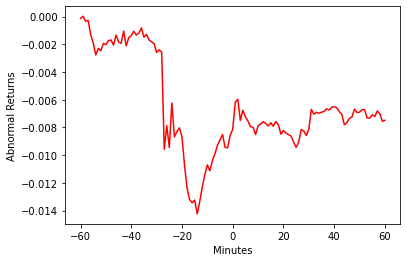

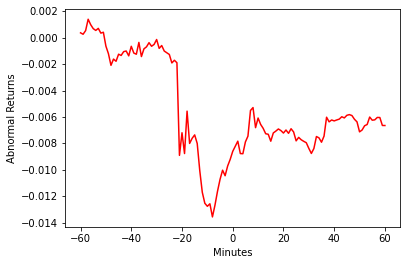

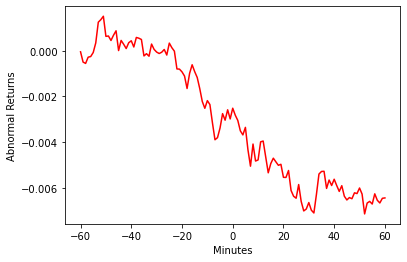

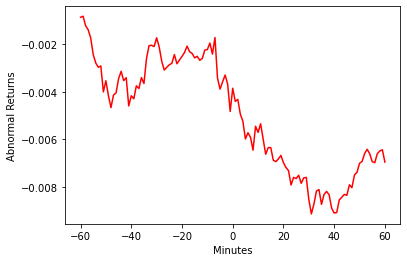

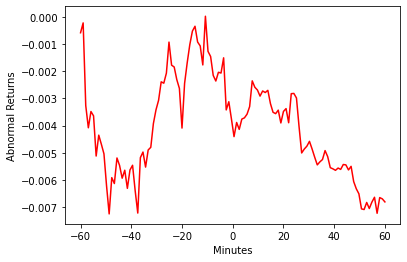

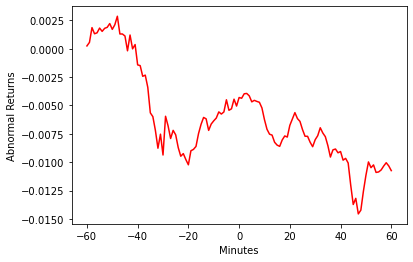

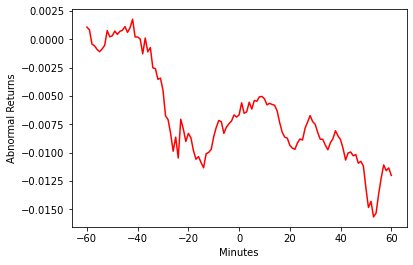

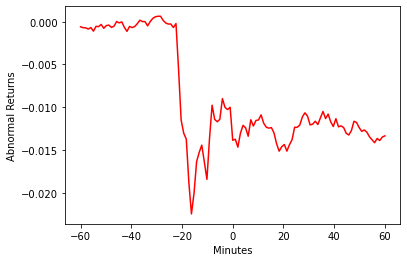

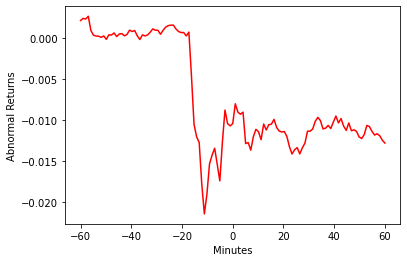

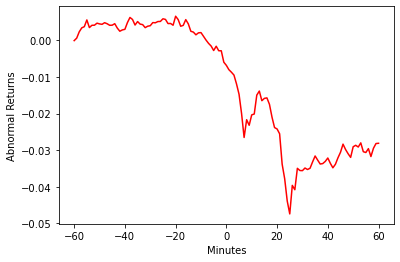

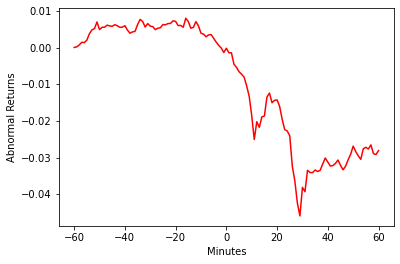

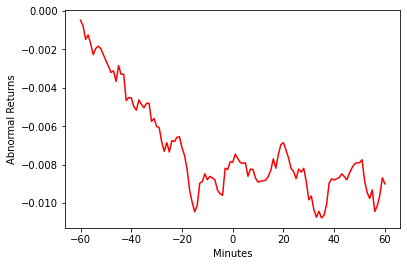

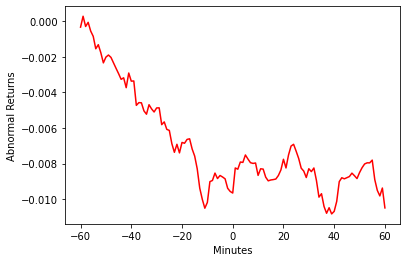

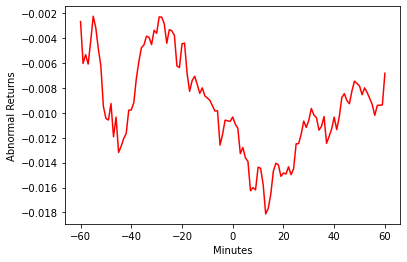

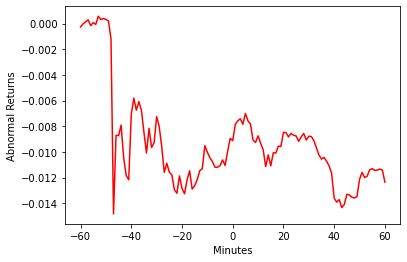

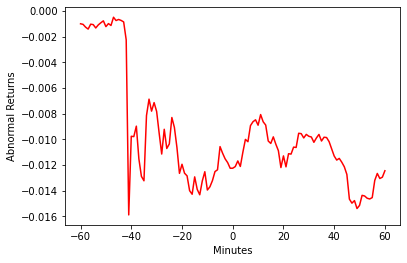

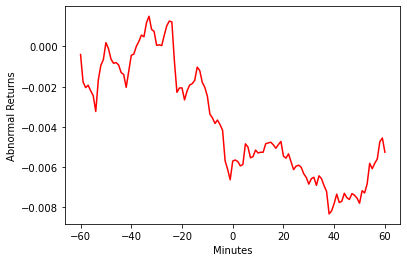

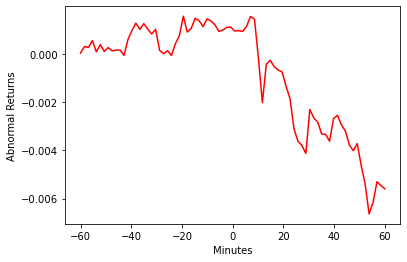

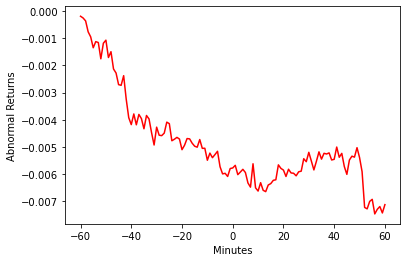

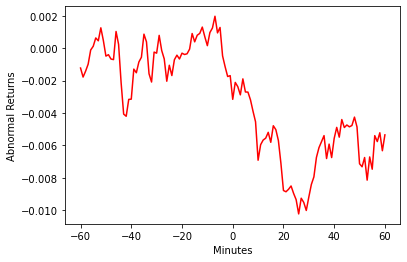

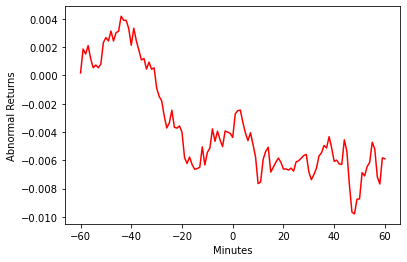

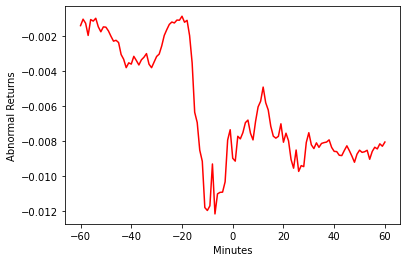

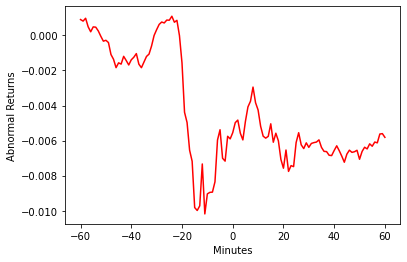

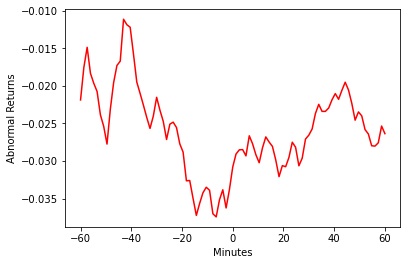

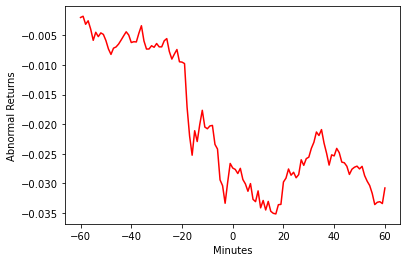

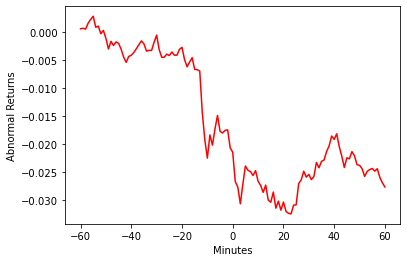

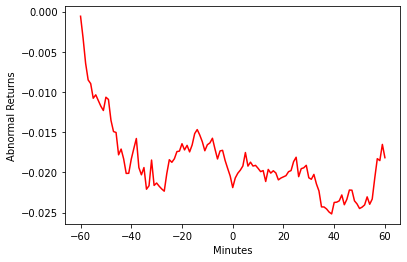

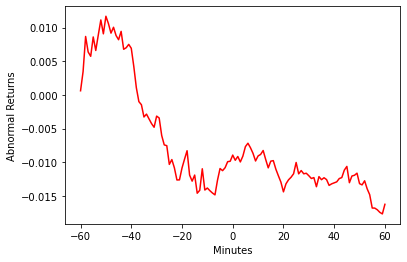

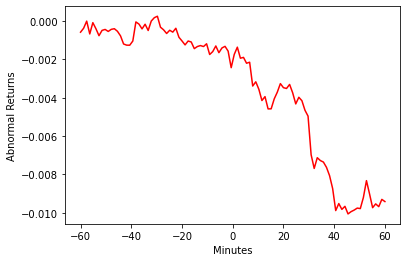

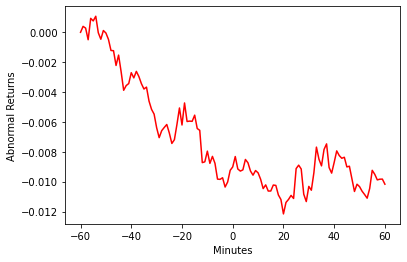

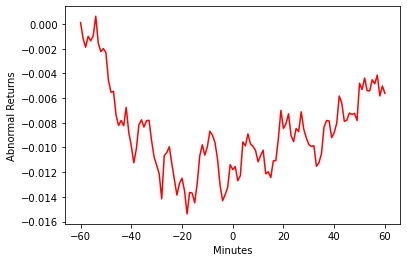

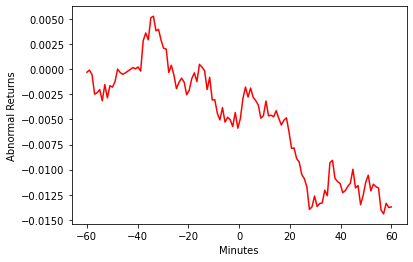

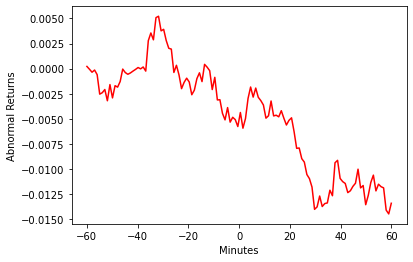

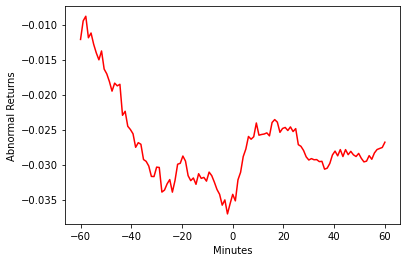

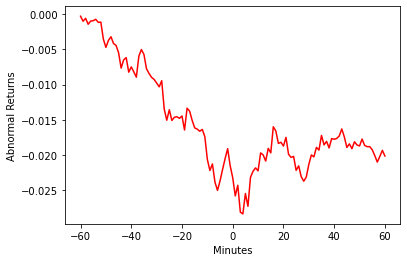

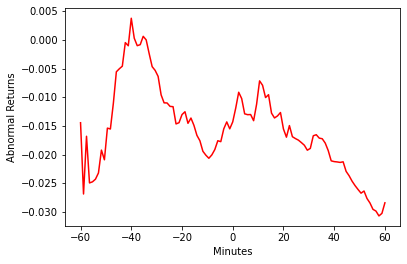

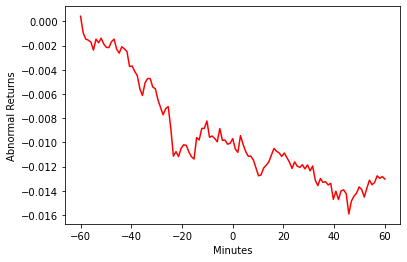

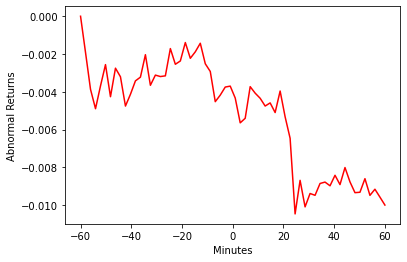

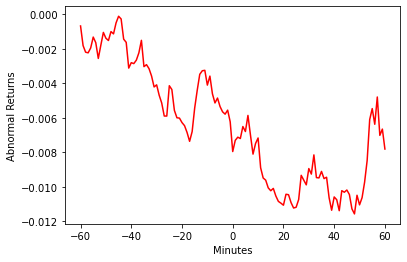

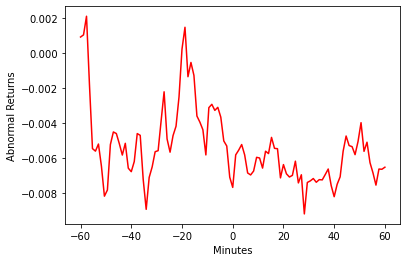

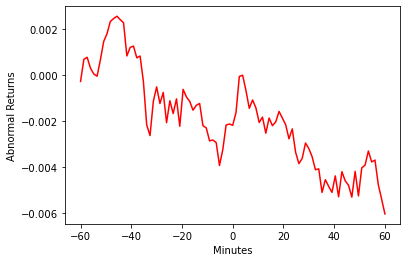

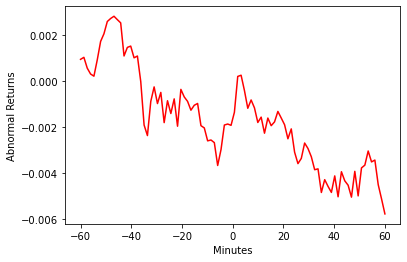

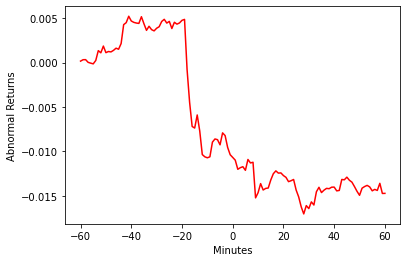

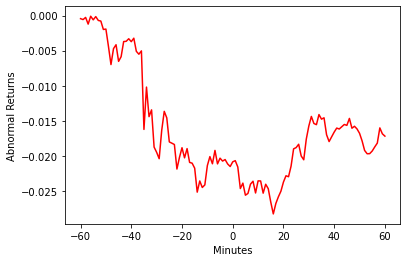

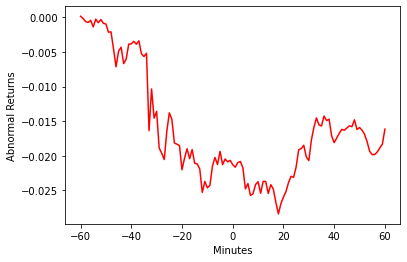

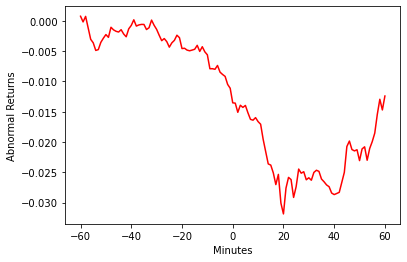

KeyError: 'AAPL'

In [62]:
for _, row in Negative.iterrows():
    
    beg_small = row['time_tz'] - pd.Timedelta("60 min")
    end_small = row['time_tz'] + pd.Timedelta("60 min")
    news_time_small = row['time_tz']
    
    for_the_small = prices[(prices['time'] >= beg_small) & (prices['time'] <= end_small)].copy()
    for_the_small['diff'] = for_the_small['time'] - news_time_small

    for_the_small['AR'] = for_the_small['R_t_' + row['ticker']] - params[row['ticker']][0] - params[row['ticker']][1] * for_the_small['R_t-1_' + row['ticker']] - params[row['ticker']][2] * for_the_small['R_m']
    for_the_small['cumAR'] = for_the_small['AR'].cumsum()

    plt.plot(np.linspace(-60,60,len(for_the_small['cumAR'])), for_the_small['cumAR'], color = 'r')
    plt.ylabel('Abnormal Returns')
    plt.xlabel('Minutes')
    plt.show()

In [63]:
def pos(row):
    if row['Score'] == 1:
        return 1
    else:
        return 0
    
def neg(row):
    if row['Score'] == -1:
        return 1
    else:
        return 0
    
News['time_tz'] = pd.to_datetime(News['time_tz'])

In [64]:
prices_AAPL = prices[['time', 'R_t_AAPL', 'R_t-1_AAPL', 'R_m']]

In [65]:
promezh = pd.DataFrame({'time': [], 'Score': []})
for _, row in News[News['ticker'] == 'AAPL'].iterrows():
    
    beg = row['time_tz'] - pd.Timedelta("60 min")
    end = row['time_tz'] + pd.Timedelta("60 min")
    news_time = row['time_tz']
    for_the_news = prices[(prices['time'] >= beg) & (prices['time'] <= end)].copy()
    for_the_news['Score'] = [row['Score']]*len(for_the_news)
    promezh = pd.concat([promezh, for_the_news[['time', 'Score']]], axis=0)
    promezh.drop_duplicates(subset=['time'])


prices_AAPL = pd.merge(prices_AAPL, promezh, on = 'time', how = 'left')

prices_AAPL['Positive'] = prices_AAPL.apply(pos, axis = 1)
prices_AAPL['Negative'] = prices_AAPL.apply(neg, axis = 1)

In [33]:
prices_AAPL['Score'] = prices_AAPL['Score'].fillna(0)

In [38]:
prices_AAPL.to_csv(r'C:\Users\kozyr\Downloads\AAPL_BERT.csv')

In [68]:
prices_AAPL.Positive.unique()

array([0, 1], dtype=int64)

In [69]:
prices_AMZN = prices[['time', 'R_t_AMZN', 'R_t-1_AMZN', 'R_m']]

promezh = pd.DataFrame({'time': [], 'Score': []})
for _, row in News[News['ticker'] == 'AMZN'].iterrows():
    
    beg = row['time_tz'] - pd.Timedelta("60 min")
    end = row['time_tz'] + pd.Timedelta("60 min")
    news_time = row['time_tz']
    for_the_news = prices[(prices['time'] >= beg) & (prices['time'] <= end)].copy()
    for_the_news['Score'] = [row['Score']]*len(for_the_news)
    promezh = pd.concat([promezh, for_the_news[['time', 'Score']]], axis=0)
    promezh.drop_duplicates(subset=['time'])


prices_AMZN = pd.merge(prices_AMZN, promezh, on = 'time', how = 'left')

prices_AMZN['Positive'] = prices_AMZN.apply(pos, axis = 1)
prices_AMZN['Negative'] = prices_AMZN.apply(neg, axis = 1)

In [71]:
prices_AMZN.to_csv(r'C:\Users\kozyr\Downloads\AMZN_BERT.csv')

In [72]:
from scipy import stats

In [75]:
stats.ttest_1samp(Negative['CAR'],0)

Ttest_1sampResult(statistic=-12.439733697909386, pvalue=1.4157100081664694e-21)